# Which one is a better plan?



The main objective of this project is to carry out a preliminary analysis of the two prepaid plans offered by the telecom operator Megaline, Surf and Ultimate. 

Based on a relatively small selection of 500 Megaline customers and focusing on who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent and the internet MB they consumed in 2018, this analysis is aimed to understand the clients' behavior and determine which prepaid plan brings in more revenue.


After getting an overview of the data, fixing any issues found along the way, and adding useful calculated fields, we will pull key variables coming from different datasets to assess how customer behavior varies between both plans and which one provides larger and more stable revenues across all month of the year, and propose potential action plans to make that plan more convenient to suscriptors.

Finally, two hypotheses will be tested:

1) The average monthly revenue from each plan is different.

2) The average monthly revenue from users based in NY/NJ is different than the rest of the cities.

## Initialization

First off, load all the neccesary libraries to process, analyze and plot data

In [195]:
# Loading all the libraries

import pandas as pd
import numpy as np
from scipy import stats as st
import math
import matplotlib.pyplot as plt

## Load data

The datasets containing info on the individual calls, messages and web sessions are to be stored in separate dataframes, as well as the table showing user's personal information and the one with each plan's features.

In [196]:
# Load the data files into different DataFrames
calls_df= pd.read_csv('/datasets/megaline_calls.csv')
internet_df= pd.read_csv('/datasets/megaline_internet.csv')
messages_df= pd.read_csv('/datasets/megaline_messages.csv')
plans_df= pd.read_csv('/datasets/megaline_plans.csv')
users_df= pd.read_csv('/datasets/megaline_users.csv')



## Prepare the data

Explore each one to get an initial understanding of the data. Do necessary corrections to each table, and add extra features that will be useful for the purpose of this analysis

## Plans

**The plans table (data on the plans):**

plan_name — calling plan name

usd_monthly_fee — monthly charge in US dollars

minutes_included — monthly minute allowance

messages_included — monthly text allowance

mb_per_month_included — data volume allowance (in megabytes)

usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)

usd_per_message — price per text after exceeding the package limits

usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

**Description of the plans**

**Surf**

Monthly charge: $20

500 monthly minutes, 50 texts, and 15 GB of data

After exceeding the package limits:

1 minute: 3 cents

1 text message: 3 cents

1 GB of data: $10

**Ultimate**

Monthly charge: $70

3000 monthly minutes, 1000 text messages, and 30 GB of data

After exceeding the package limits:

1 minute: 1 cent

1 text message: 1 cent

1 GB of data: $7


In [197]:
# Print the general/summary information about the plans' DataFrame
plans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [198]:
# Print a sample of data for plans
plans_df

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


### Fix Data

**No missing values or errors in data types were identified in this table**


However, since monthly megabytes consumption will be rounded up to Gigabytes, mb_per_month_included should be expressed in this same unit.



In [199]:
#change MB by GB

plans_df['mb_per_month_included'] = plans_df['mb_per_month_included'].apply(lambda x:int(x/1024)) 

plans_df

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


In [200]:
#change column name
plans_df.rename(columns={'mb_per_month_included': 'gb_per_month_included'}, inplace=True)

In [201]:
#Print and check the result
plans_df

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


### Enrich Data

**Set plan name as index**

For more easily joining user's information with data on their telecom plan, the latter's name will be set as the dataframe index.



In [202]:
#Set plan name as index and drop plan_name column
plans_df.index=plans_df['plan_name']
plans_df.drop(columns='plan_name',inplace=True)
plans_df

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
plan_name,,,,,,,
surf,50,15,500,20,10,0.03,0.03
ultimate,1000,30,3000,70,7,0.01,0.01


## Users


**The users table (data on users):**

user_id — unique user identifier

first_name — user's name

last_name — user's last name

age — user's age (years)

reg_date — subscription date (dd, mm, yy)

churn_date — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)

city — user's city of residence

plan — calling plan name

In [203]:
# Print the general/summary information about the users' DataFrame

users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [204]:
#print head
users_df.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


### Fix Data

**Data types**

user_id & age are correctly stored as integers. 
reg_date & churn date are to be converted to datetime.




In [205]:
#print top rows with churn date not missing

users_df.query('churn_date.isna()==False').head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
22,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07
40,1040,Paris,Santos,72,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-12-23,surf,2018-12-30
50,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07


In [206]:
#convert reg_date to datetime
users_df['reg_date']=pd.to_datetime(users_df['reg_date'], format='%Y-%m-%d')

In [207]:
#print info of converted data
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
churn_date    34 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [208]:
#total of missing values
users_df['churn_date'].isna().sum()

466


**Missing values:**

The only column with missing values is: **churn_date**. The empty cells add up to 466.

As the Database contains values for the year 2018 and missing values mean the calling plan was being used when this database was extracted, they will be replaced by the following year start date (1/1/2019). The idea of not using the year end date is to distinguish the ones that were still active at the end of the year from the ones whose churn date matches the last day of the year.



In [209]:
# create a variable storing the year end date
year_end= pd.datetime(2018,12,31)
year_end= pd.Series(year_end).dt.date[0]
year_end.year

2018

In [210]:
# create a variable storing the next year start date
next_year_start = pd.datetime(2019,1,1)
next_year_start= pd.Series(next_year_start).dt.date[0]
next_year_start

datetime.date(2019, 1, 1)

In [211]:
#fill missing values in churn_date with next year start date

users_df.fillna(next_year_start, inplace=True)
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
churn_date    500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [212]:
#convert churn_date to datetime
users_df['churn_date']=pd.to_datetime(users_df['churn_date'], format='%Y-%m-%d')

In [213]:
#Print info and check conversion
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null datetime64[ns]
plan          500 non-null object
churn_date    500 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Enrich Data


**Registration month and churn month:**

Since revenue from each user will be calculated on a monthly basis, two columns will be added: reg_month and churn_month.

Based on their values, it's easy to calculate whether the user was active (was charged with the monthly pay) at a given month.

This will be estimated on the assumption that user's are charged both for the month they suscribed and the month they discontinued the service, regardless of the day of the month at which they became active/inactive and the calls, messages or GB they used.




In [214]:
#add reg month
users_df['reg_month']= users_df['reg_date'].dt.month
users_df

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-01,12
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,8
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2019-01-01,10
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2019-01-01,1
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2019-01-01,5
...,...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,2019-01-01,9
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,2019-01-01,2
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,2019-01-01,12
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,2019-01-01,2


In [215]:
#add churn month. If user was active at the year end, set it as 13.

users_df['churn_month']=''

for i in range(len(users_df)):
    if users_df.loc[i,'churn_date'].year == year_end.year:
        users_df.loc[i,'churn_month']= users_df.loc[i,'churn_date'].month
    else:
        users_df.loc[i,'churn_month']=13
users_df

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,churn_month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2019-01-01,12,13
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2019-01-01,8,13
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2019-01-01,10,13
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2019-01-01,1,13
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2019-01-01,5,13
...,...,...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,2019-01-01,9,13
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,2019-01-01,2,13
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,2019-01-01,12,13
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,2019-01-01,2,13


## Calls

**The calls table (data on calls):**

id — unique call identifier

call_date — call date

duration — call duration (in minutes)

user_id — the identifier of the user making the call

In [216]:
# Print the general/summary information about the calls' DataFrame
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [217]:
# Print a sample of data for calls
calls_df.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


### Fix data


**Data types:**

call_date is to be converted to datetime, and duration will be rounded up, since even if the call lasted just one second, it will be counted as one minute for invoicing.

There are no missing values in this dataframe



In [218]:
#Convert call_date to datetime
calls_df['call_date']= pd.to_datetime(calls_df['call_date'])

In [219]:
#Round up duration
calls_df['duration']= calls_df['duration'].apply(lambda x: int(math.ceil(x)))

In [220]:
#Print result
calls_df.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


In [221]:
#Print info to check data types were converted correctly
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null datetime64[ns]
duration     137735 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ MB


In [222]:
#Print top values to check duration was correctly rounded up
calls_df.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


### Enrich data


**Call month**

Based on each call date, we'll add a column with the month at which they took place for adding up the total minutes cost per user each period. Also, "duration" column will be changed by "call_duration".



In [223]:
#add call month
calls_df['call_month']= calls_df['call_date'].dt.month
calls_df

,id,user_id,call_date,duration,call_month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,9,11
137731,1499_200,1499,2018-10-20,11,10
137732,1499_201,1499,2018-09-21,9,9
137733,1499_202,1499,2018-10-10,1,10


In [224]:
#rename duration column
calls_df.rename(columns={'duration':'call_duration'}, inplace=True)
calls_df

,id,user_id,call_date,call_duration,call_month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,9,11
137731,1499_200,1499,2018-10-20,11,10
137732,1499_201,1499,2018-09-21,9,9
137733,1499_202,1499,2018-10-10,1,10


## Messages

**The messages table (data on texts):**

id — unique text message identifier

message_date — text message date

user_id — the identifier of the user sending the text

In [225]:
# Print the general/summary information about the messages' DataFrame

messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [226]:
# Print a sample of data for messages
messages_df.sample(5)

,id,user_id,message_date
62956,1399_21,1399,2018-08-14
49652,1328_610,1328,2018-07-27
66680,1434_212,1434,2018-08-02
66844,1434_397,1434,2018-10-29
70138,1455_74,1455,2018-11-30


### Fix data


**Data types:**

message_date is to be converted to datetime.

There are no missing values in this dataframe



In [227]:
#change message_date to datetime
messages_df['message_date']= pd.to_datetime(messages_df['message_date'], format='%Y-%m-%d')
messages_df

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24


In [228]:
#check the change
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enrich data

Message month: Based on the date each message was sent, we will add a column with the month for adding up the total messages sent per user each monthly period. 

In [229]:
#add message month
messages_df['message_month']= messages_df['message_date'].dt.month
messages_df

,id,user_id,message_date,message_month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12
...,...,...,...,...
76046,1497_526,1497,2018-12-24,12
76047,1497_536,1497,2018-12-24,12
76048,1497_547,1497,2018-12-31,12
76049,1497_558,1497,2018-12-24,12


## Internet

**The internet table (data on web sessions):**

id — unique session identifier

mb_used — the volume of data spent during the session (in megabytes)

session_date — web session date

user_id — user identifier


In [230]:
# Print a sample of data for the internet traffic
internet_df.sample(5)

,id,user_id,session_date,mb_used
61973,1281_261,1281,2018-11-06,757.97
62161,1283_59,1283,2018-12-31,831.77
13575,1064_23,1064,2018-11-17,191.28
72094,1336_107,1336,2018-07-29,212.94
21059,1098_85,1098,2018-11-02,67.03


In [231]:
internet_df.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [232]:
# Print the general/summary information about the internet DataFrame
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


### Fix data


**Data types:**

session_date is to be converted to datetime.

**Missing values**

There are no missing values in this dataframe.


**Calculated columns**

For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes. Hence, MB will be first totalized per used_id & month, and rounded up later on.



In [233]:
#change session date to datetime
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'])


### Enrich data

session month: Based on the date of each session, we will add a column with the month for adding up the total MB used per user in each monthly period. 

In [234]:
#add column with month
internet_df['session_month']= internet_df['session_date'].dt.month
internet_df

,id,user_id,session_date,mb_used,session_month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12
...,...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06,10
104821,1499_216,1499,2018-12-30,304.72,12
104822,1499_217,1499,2018-09-22,292.75,9
104823,1499_218,1499,2018-12-07,0.00,12


In [235]:
#print info and check dtypes
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
id               104825 non-null object
user_id          104825 non-null int64
session_date     104825 non-null datetime64[ns]
mb_used          104825 non-null float64
session_month    104825 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 4.0+ MB


## Study plan conditions

In [236]:
# Print out the plan conditions once again

plans_df

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
plan_name,,,,,,,
surf,50,15,500,20,10,0.03,0.03
ultimate,1000,30,3000,70,7,0.01,0.01


## Aggregate data per user

Data from all sets will be aggregated monthly. Since the sample size adds up to 500 users, and the period under analysis includes 12 months, a new dataframe of length 500 x 12 will be created (6000 rows).

In [237]:
# Calculate the number of calls made by each user per month. Save the result.

calls_monthly= calls_df.pivot_table(index=['call_month','user_id'], values='id', aggfunc='count')
calls_monthly

id
call_month user_id    
1          1042     18
           1077     42
           1185     23
           1196     42
           1214      5
...                 ..
12         1495     65
           1496     40
           1497     54
           1498     39
           1499     65

[2258 rows x 1 columns]

In [238]:
# Calculate the amount of minutes spent by each user per month. Save the result.

calls_monthly_duration= calls_df.pivot_table(index=['call_month','user_id'], values='call_duration', aggfunc='sum')
calls_monthly_duration

call_duration
call_month user_id               
1          1042               114
           1077               290
           1185               181
           1196               287
           1214                16
...                           ...
12         1495               492
           1496               294
           1497               300
           1498               339
           1499               496

[2258 rows x 1 columns]

In [239]:
# Calculate the number of messages sent by each user per month. Save the result.

msg_monthly= messages_df.pivot_table(index=['message_month','user_id'], values='id', aggfunc='count')
msg_monthly

id
message_month user_id    
1             1077     37
              1196     23
              1214      2
              1362     21
2             1028     12
...                    ..
12            1491     43
              1492     37
              1494     33
              1496     11
              1497     50

[1806 rows x 1 columns]

In [240]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_monthly= internet_df.pivot_table(index=['session_month','user_id'], values='mb_used', aggfunc='sum')
internet_monthly

mb_used
session_month user_id          
1             1042      1854.93
              1077     10635.64
              1185      6812.77
              1196      8908.61
              1214      1315.35
...                         ...
12            1495     24097.40
              1496     16438.99
              1497     11106.55
              1498     23137.69
              1499     22059.21

[2277 rows x 1 columns]

In [241]:
#round up mb used to gb
internet_monthly['mb_used']=internet_monthly['mb_used'].apply(lambda x: int(math.ceil(x/1024)))


In [242]:
#change column name 
internet_monthly.rename(columns={'mb_used': 'gb_used'}, inplace=True)
#Print df
internet_monthly

gb_used
session_month user_id         
1             1042           2
              1077          11
              1185           7
              1196           9
              1214           2
...                        ...
12            1495          24
              1496          17
              1497          11
              1498          23
              1499          22

[2277 rows x 1 columns]

The next step is to put the aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month (as explained before the length will be of 6000 rows -500 users x 12 months-)

In [243]:
# Create a multi-index DF with month & user_id

index = pd.MultiIndex.from_product([[  i for i in range(1,13) ],
                                    [user for user in list(users_df['user_id'].unique())]
                                  ],
                                 names=['month', 'user_id'])
column=['fake']

user_month_df = pd.DataFrame('-', index, column)     
user_month_df

fake
month user_id     
1     1000       -
      1001       -
      1002       -
      1003       -
      1004       -
...            ...
12    1495       -
      1496       -
      1497       -
      1498       -
      1499       -

[6000 rows x 1 columns]

In [244]:
#Merge the data for calls, minutes, messages, internet based on user_id and month
user_month_df= user_month_df.merge(calls_monthly_duration,left_index=True, right_on=['call_month','user_id'], how='left' )
#drop fake column
user_month_df.drop(columns=['fake'],inplace=True)
user_month_df

call_duration
call_month user_id               
1          1000               NaN
           1001               NaN
           1002               NaN
           1003               NaN
           1004               NaN
...                           ...
12         1495             492.0
           1496             294.0
           1497             300.0
           1498             339.0
           1499             496.0

[6000 rows x 1 columns]

In [245]:
#add messages_sent and rename the column
user_month_df= user_month_df.merge(msg_monthly,left_index=True, right_on=['message_month','user_id'],how='left' )
user_month_df.rename(columns={'id': 'messages_sent'},inplace=True)
user_month_df


call_duration  messages_sent
message_month user_id                              
1             1000               NaN            NaN
              1001               NaN            NaN
              1002               NaN            NaN
              1003               NaN            NaN
              1004               NaN            NaN
...                              ...            ...
12            1495             492.0            NaN
              1496             294.0           11.0
              1497             300.0           50.0
              1498             339.0            NaN
              1499             496.0            NaN

[6000 rows x 2 columns]

In [246]:
#add GB consumed
user_month_df=user_month_df.merge(internet_monthly,left_index=True, right_on=['session_month','user_id'],how='left' )
user_month_df

call_duration  messages_sent  gb_used
session_month user_id                                       
1             1000               NaN            NaN      NaN
              1001               NaN            NaN      NaN
              1002               NaN            NaN      NaN
              1003               NaN            NaN      NaN
              1004               NaN            NaN      NaN
...                              ...            ...      ...
12            1495             492.0            NaN     24.0
              1496             294.0           11.0     17.0
              1497             300.0           50.0     11.0
              1498             339.0            NaN     23.0
              1499             496.0            NaN     22.0

[6000 rows x 3 columns]

In [247]:
#Print info
user_month_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6000 entries, (1, 1000) to (12, 1499)
Data columns (total 3 columns):
call_duration    2258 non-null float64
messages_sent    1806 non-null float64
gb_used          2277 non-null float64
dtypes: float64(3)
memory usage: 162.4 KB


Since the missing values mean there were no calls, messaged sent or gb_used for a given user in that specific month, they'll be filled with "0"

In [248]:
#fill missing values with 0

user_month_df=user_month_df.fillna(0)

In [249]:
#Print info

user_month_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6000 entries, (1, 1000) to (12, 1499)
Data columns (total 3 columns):
call_duration    6000 non-null float64
messages_sent    6000 non-null float64
gb_used          6000 non-null float64
dtypes: float64(3)
memory usage: 162.4 KB


In [250]:
#Change index to columns

user_month_df.reset_index(inplace=True)
user_month_df


,session_month,user_id,call_duration,messages_sent,gb_used
0,1,1000,0.0,0.0,0.0
1,1,1001,0.0,0.0,0.0
2,1,1002,0.0,0.0,0.0
3,1,1003,0.0,0.0,0.0
4,1,1004,0.0,0.0,0.0
...,...,...,...,...,...
5995,12,1495,492.0,0.0,24.0
5996,12,1496,294.0,11.0,17.0
5997,12,1497,300.0,50.0,11.0
5998,12,1498,339.0,0.0,23.0


In [251]:
# Add the user information to user_month_df
user_month_df= user_month_df.merge(users_df[['user_id', 'plan','reg_month', 'churn_month','reg_date','churn_date','city']], right_on='user_id', left_on='user_id', how='left')
user_month_df

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city
0,1,1000,0.0,0.0,0.0,ultimate,12,13,2018-12-24,2019-01-01,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1,1001,0.0,0.0,0.0,surf,8,13,2018-08-13,2019-01-01,"Seattle-Tacoma-Bellevue, WA MSA"
2,1,1002,0.0,0.0,0.0,surf,10,13,2018-10-21,2019-01-01,"Las Vegas-Henderson-Paradise, NV MSA"
3,1,1003,0.0,0.0,0.0,surf,1,13,2018-01-28,2019-01-01,"Tulsa, OK MSA"
4,1,1004,0.0,0.0,0.0,surf,5,13,2018-05-23,2019-01-01,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...,...,...,...,...,...,...,...,...
5995,12,1495,492.0,0.0,24.0,surf,9,13,2018-09-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA"
5996,12,1496,294.0,11.0,17.0,surf,2,13,2018-02-20,2019-01-01,"New Orleans-Metairie, LA MSA"
5997,12,1497,300.0,50.0,11.0,ultimate,12,13,2018-12-10,2019-01-01,"Los Angeles-Long Beach-Anaheim, CA MSA"
5998,12,1498,339.0,0.0,23.0,surf,2,13,2018-02-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA"


In [252]:
#add plan features to user_month_df

user_month_df=user_month_df.merge(plans_df, left_on='plan', right_index=True, how='left')
user_month_df

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1,1000,0.0,0.0,0.0,ultimate,12,13,2018-12-24,2019-01-01,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30,3000,70,7,0.01,0.01
1,1,1001,0.0,0.0,0.0,surf,8,13,2018-08-13,2019-01-01,"Seattle-Tacoma-Bellevue, WA MSA",50,15,500,20,10,0.03,0.03
2,1,1002,0.0,0.0,0.0,surf,10,13,2018-10-21,2019-01-01,"Las Vegas-Henderson-Paradise, NV MSA",50,15,500,20,10,0.03,0.03
3,1,1003,0.0,0.0,0.0,surf,1,13,2018-01-28,2019-01-01,"Tulsa, OK MSA",50,15,500,20,10,0.03,0.03
4,1,1004,0.0,0.0,0.0,surf,5,13,2018-05-23,2019-01-01,"Seattle-Tacoma-Bellevue, WA MSA",50,15,500,20,10,0.03,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,12,1495,492.0,0.0,24.0,surf,9,13,2018-09-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03
5996,12,1496,294.0,11.0,17.0,surf,2,13,2018-02-20,2019-01-01,"New Orleans-Metairie, LA MSA",50,15,500,20,10,0.03,0.03
5997,12,1497,300.0,50.0,11.0,ultimate,12,13,2018-12-10,2019-01-01,"Los Angeles-Long Beach-Anaheim, CA MSA",1000,30,3000,70,7,0.01,0.01
5998,12,1498,339.0,0.0,23.0,surf,2,13,2018-02-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03


Next we'll calculate the monthly revenue from each user as follows:

1) Add a column set to True (1) if the user reg_date is less than or equal to the session month (month for which revenue is calculated) and churn month is greater than or equal to the session month (means the user paid the basic fee for that month even if no calls, messages or GB data exists for the period.

2) Set revenue = monthly pay if user_active = 1, or to 0 otherwise.

3) Subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan.

In [253]:
#calculate if user was active that month:
def user_active (row):
    ''' 
    Returns 1 if reg_month <= session_month
    and churn_month >= session_month
    or 0 otherwise.
                
    '''
    session_month= row['session_month']
    reg_month=row['reg_month']
    churn_month=row['churn_month']
    
    
    
    return int(reg_month<=session_month and churn_month>=session_month)

        

In [254]:
#create new column with user_active value
user_month_df ['user_active'] = user_month_df.apply(user_active, axis=1)

In [255]:
#print sample
user_month_df

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_active
0,1,1000,0.0,0.0,0.0,ultimate,12,13,2018-12-24,2019-01-01,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30,3000,70,7,0.01,0.01,0
1,1,1001,0.0,0.0,0.0,surf,8,13,2018-08-13,2019-01-01,"Seattle-Tacoma-Bellevue, WA MSA",50,15,500,20,10,0.03,0.03,0
2,1,1002,0.0,0.0,0.0,surf,10,13,2018-10-21,2019-01-01,"Las Vegas-Henderson-Paradise, NV MSA",50,15,500,20,10,0.03,0.03,0
3,1,1003,0.0,0.0,0.0,surf,1,13,2018-01-28,2019-01-01,"Tulsa, OK MSA",50,15,500,20,10,0.03,0.03,1
4,1,1004,0.0,0.0,0.0,surf,5,13,2018-05-23,2019-01-01,"Seattle-Tacoma-Bellevue, WA MSA",50,15,500,20,10,0.03,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,12,1495,492.0,0.0,24.0,surf,9,13,2018-09-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03,1
5996,12,1496,294.0,11.0,17.0,surf,2,13,2018-02-20,2019-01-01,"New Orleans-Metairie, LA MSA",50,15,500,20,10,0.03,0.03,1
5997,12,1497,300.0,50.0,11.0,ultimate,12,13,2018-12-10,2019-01-01,"Los Angeles-Long Beach-Anaheim, CA MSA",1000,30,3000,70,7,0.01,0.01,1
5998,12,1498,339.0,0.0,23.0,surf,2,13,2018-02-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03,1


In [256]:
# create function to calculate the monthly revenue for each user

def monthly_revenue (row):
    ''' 
    Calculates the monthly revenue per user.
    If the user registered after that month, or the churn rate is before that month, revenue for the period is 0.
    
    If session_month (period for which the revenue is calculated) is the same as registry month or churn month 
    and calls duration is 0, messages sent is 0 and gb used is 0, revenue will still add up to
    the user's plan monthly charge in US dollars on the assumption that the
    users are charged with the fee from the month of suscription up until the churn month, regardless
    of the day of the month they hired or resigned the service.
    
    Otherwise, revenue will be equal to the user's plan monthly charge in US dollars
    plus the price per minute/messages/gb after exceeding the package limits.
                
    '''
    session_month= row['session_month']
    reg_month=row['reg_month']
    churn_month=row['churn_month']
    call_minutes= row['call_duration']
    msg_sent = row['messages_sent']
    gb_used = row['gb_used']
    minutes_inc= row['minutes_included']
    msg_inc = row['messages_included']
    gb_inc = row['gb_per_month_included']    
    monthly_pay= row['usd_monthly_pay']
    usd_per_minute = row['usd_per_minute']
    usd_per_message= row['usd_per_message']
    usd_per_gb= row['usd_per_gb']
    
    revenue=0
    if reg_month<=session_month and churn_month>=session_month:
        revenue+= monthly_pay

        if call_minutes > minutes_inc:
            revenue+= (call_minutes-minutes_inc)*usd_per_minute
        if msg_sent > msg_inc:
            revenue+= (msg_sent-msg_inc)*usd_per_message
        if gb_used > gb_inc:
            revenue+= (gb_used-gb_inc)*usd_per_gb

    return revenue
        
        
    

In [257]:
#Apply to user_month_df and set result in column "monthly_revenue"

user_month_df ['monthly_revenue'] = user_month_df.apply(monthly_revenue, axis=1)

#preview the result in active users
user_month_df.query('session_month>=reg_month and session_month<=churn_month')

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_active,monthly_revenue
3,1,1003,0.0,0.0,0.0,surf,1,13,2018-01-28,2019-01-01,"Tulsa, OK MSA",50,15,500,20,10,0.03,0.03,1,20.0
11,1,1011,0.0,0.0,0.0,ultimate,1,13,2018-01-18,2019-01-01,"Cleveland-Elyria, OH MSA",1000,30,3000,70,7,0.01,0.01,1,70.0
19,1,1019,0.0,0.0,0.0,surf,1,13,2018-01-16,2019-01-01,"Jacksonville, FL MSA",50,15,500,20,10,0.03,0.03,1,20.0
29,1,1029,0.0,0.0,0.0,surf,1,13,2018-01-05,2019-01-01,"Tampa-St. Petersburg-Clearwater, FL MSA",50,15,500,20,10,0.03,0.03,1,20.0
42,1,1042,114.0,0.0,2.0,surf,1,13,2018-01-15,2019-01-01,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",50,15,500,20,10,0.03,0.03,1,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,12,1495,492.0,0.0,24.0,surf,9,13,2018-09-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03,1,110.0
5996,12,1496,294.0,11.0,17.0,surf,2,13,2018-02-20,2019-01-01,"New Orleans-Metairie, LA MSA",50,15,500,20,10,0.03,0.03,1,40.0
5997,12,1497,300.0,50.0,11.0,ultimate,12,13,2018-12-10,2019-01-01,"Los Angeles-Long Beach-Anaheim, CA MSA",1000,30,3000,70,7,0.01,0.01,1,70.0
5998,12,1498,339.0,0.0,23.0,surf,2,13,2018-02-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03,1,100.0


In [258]:
#Check that active users were set correctly
user_month_df.query('user_active==0 and session_month>= reg_month and session_month<=churn_month')

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_active,monthly_revenue


In [259]:
#Create df with active users only
active_users_df= user_month_df.query('user_active==1')

#reset index of active users df
active_users_df.reset_index(inplace=True, drop=True)
active_users_df

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_active,monthly_revenue
0,1,1003,0.0,0.0,0.0,surf,1,13,2018-01-28,2019-01-01,"Tulsa, OK MSA",50,15,500,20,10,0.03,0.03,1,20.0
1,1,1011,0.0,0.0,0.0,ultimate,1,13,2018-01-18,2019-01-01,"Cleveland-Elyria, OH MSA",1000,30,3000,70,7,0.01,0.01,1,70.0
2,1,1019,0.0,0.0,0.0,surf,1,13,2018-01-16,2019-01-01,"Jacksonville, FL MSA",50,15,500,20,10,0.03,0.03,1,20.0
3,1,1029,0.0,0.0,0.0,surf,1,13,2018-01-05,2019-01-01,"Tampa-St. Petersburg-Clearwater, FL MSA",50,15,500,20,10,0.03,0.03,1,20.0
4,1,1042,114.0,0.0,2.0,surf,1,13,2018-01-15,2019-01-01,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",50,15,500,20,10,0.03,0.03,1,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,12,1495,492.0,0.0,24.0,surf,9,13,2018-09-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03,1,110.0
3309,12,1496,294.0,11.0,17.0,surf,2,13,2018-02-20,2019-01-01,"New Orleans-Metairie, LA MSA",50,15,500,20,10,0.03,0.03,1,40.0
3310,12,1497,300.0,50.0,11.0,ultimate,12,13,2018-12-10,2019-01-01,"Los Angeles-Long Beach-Anaheim, CA MSA",1000,30,3000,70,7,0.01,0.01,1,70.0
3311,12,1498,339.0,0.0,23.0,surf,2,13,2018-02-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03,1,100.0


## Study user behaviour

Below, we'll calculate some useful descriptive statistics for the aggregated and merged data, to get some insight on the overall picture captured by the data. 

For such purpose, we'll draw useful plots to help the understanding. 


Given that the main task is to compare the plans and decide on which one is more profitable, the statistics and the plots should be calculated on a per-plan basis.


### Calls

In [260]:
# Compare average duration of calls per each plan per each distinct month. 

avg_duration = active_users_df.pivot_table(index='session_month',columns='plan', values='call_duration', aggfunc='mean')
avg_duration

plan,surf,ultimate
session_month,,
1,13.533333,40.736842
2,44.550000,91.032258
3,84.333333,89.048780
4,141.750000,136.038462
5,206.496644,181.246154
6,231.138122,200.402299
7,265.600000,254.515152
8,282.714894,254.121739
9,315.137255,296.032000


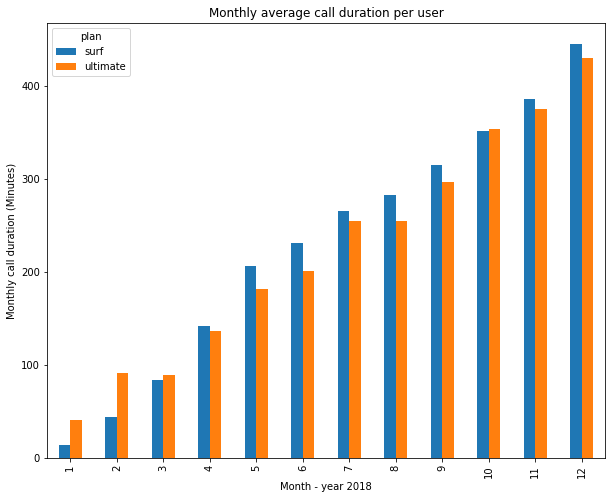

In [334]:
#Plot a bar plot of average duration of total calls per month to visualize it.
avg_duration.plot(kind='bar', figsize=(10,8))
plt.title('Monthly average call duration per user')
plt.ylabel('Monthly call duration (Minutes)')
plt.xlabel('Month - year 2018')
plt.show()


In [262]:
# Compare the number of users active each month
total_users = active_users_df.pivot_table(index='session_month',columns='plan', values='user_active', aggfunc='sum')
total_users

plan,surf,ultimate
session_month,,
1,30,19
2,60,31
3,90,41
4,124,52
5,149,65
6,181,87
7,205,99
8,235,115
9,255,125


Text(0.5, 1.0, 'User monthly call duration - ultimate plan')

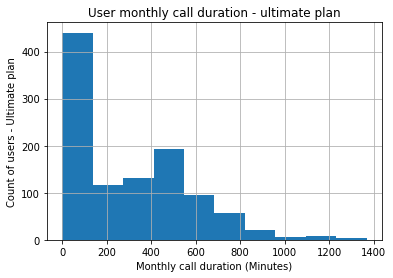

In [335]:
#Plot a histogram of ultimate plan call minutes distribution
active_users_df.query('plan=="ultimate"')['call_duration'].hist()
plt.ylabel('Count of users - Ultimate plan')
plt.xlabel('Monthly call duration (Minutes)')
plt.title('User monthly call duration - ultimate plan')

Text(0.5, 1.0, 'User monthly call duration - Surf plan')

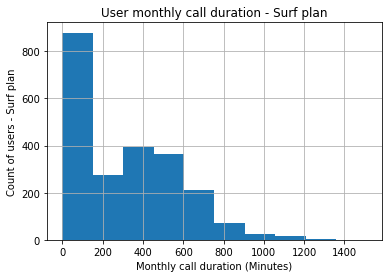

In [336]:
#Plot a histogram of surf plan call minutes distribution
active_users_df.query('plan=="surf"')['call_duration'].hist()
plt.ylabel('Count of users - Surf plan')
plt.xlabel('Monthly call duration (Minutes)')
plt.title('User monthly call duration - Surf plan')

Calculate the mean and the variable of the call duration to assess whether users on the different plans have different behaviours for their calls.

In [265]:
# Calculate the mean and the variance of the monthly call duration
active_users_df.query('plan=="ultimate"')['call_duration'].describe()

count    1071.000000
mean      284.357610
std       282.603619
min         0.000000
25%         0.000000
50%       253.000000
75%       482.000000
max      1369.000000
Name: call_duration, dtype: float64

In [266]:
np.var(active_users_df.query('plan=="ultimate"')['call_duration'])

79790.23532724637

In [267]:

active_users_df.query('plan=="surf" ')[ 'call_duration'].describe()


count    2242.000000
mean      296.070027
std       278.414564
min         0.000000
25%         0.000000
50%       290.500000
75%       498.000000
max      1510.000000
Name: call_duration, dtype: float64

In [268]:
np.var(active_users_df.query('plan=="surf"')['call_duration'])

77480.0954530769

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


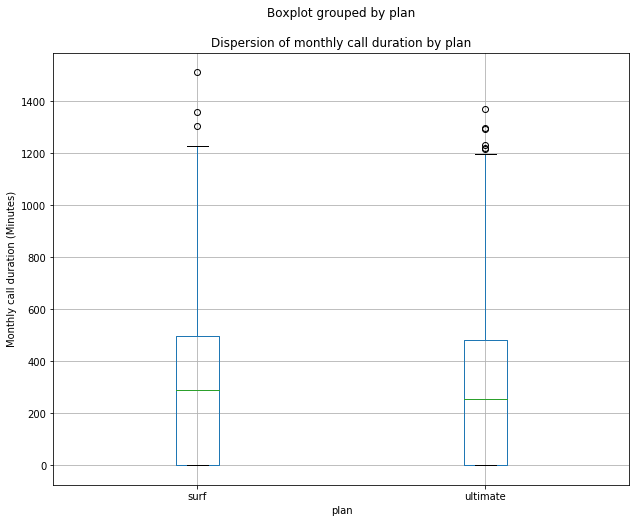

In [337]:

active_users_df.boxplot(by='plan',column='call_duration', figsize=(10,8))
plt.ylabel('Monthly call duration (Minutes)')
plt.xlabel('plan')
plt.title('Dispersion of monthly call duration by plan')
plt.show()

In [270]:
plans_df

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
plan_name,,,,,,,
surf,50,15,500,20,10,0.03,0.03
ultimate,1000,30,3000,70,7,0.01,0.01


From the charts drawn and the statistics printed above, the conclusion is that users of both plans have a very similar behaviour:

1) The average call duration increases gradually from month to month. Surf plan users average ends up exceeding ultimate plan's but not in a large amount.

2) The distribution of the calls duration follows a similar pattern: it's positively skewed, with the majority of users spending less than 200 minutes most months.

One odd feature is that moving forward from that peak, ultimate users (which includes 3000 minutes monthly) show a second spike falling below the 500 minutes, whereas surf users extend duration up to 600 mintues (they have 500 included in their plan).

The rest of the user monthly call durations are outliers starting roughly at 800 minutes and reaching the 1400 minutes monthly per user.

3) The mean and median of both plans fall between 250 and 300 minutes, both with a similar variance. In the boxplots we can observe surf users have a higher median and greater outliers, but ultimate has more outliers. Still, the boxes and the whiskers indicate a very similar dispersion. 

Another relevant observation is that the 75% of the times, users of both plans spent less than the 500 minutes included in Surf, which is the cheapest one. Besides, the maximum excess paid for extra minutes was only (1510 min -500 min) x USD 0.03 = USD 30. 
On their side, ultimate users maximum monthly call duration was less than half of the 3000 minutes included in their plan. 




### Messages

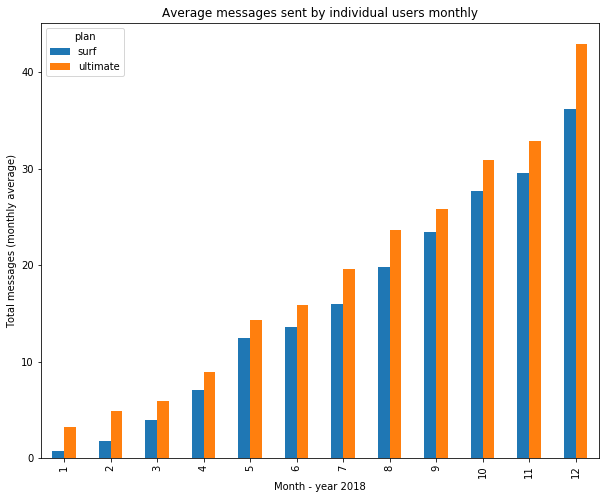

In [338]:
# Compare the number of messages users of each plan tend to send each month
avg_messages= active_users_df.pivot_table(index='session_month',columns='plan', values='messages_sent', aggfunc='mean')
avg_messages.plot(kind='bar', figsize=(10,8))
plt.title('Average messages sent by individual users monthly')
plt.ylabel('Total messages (monthly average)')
plt.xlabel('Month - year 2018')

plt.show()

Text(0.5, 0, 'Messages sent monthly')

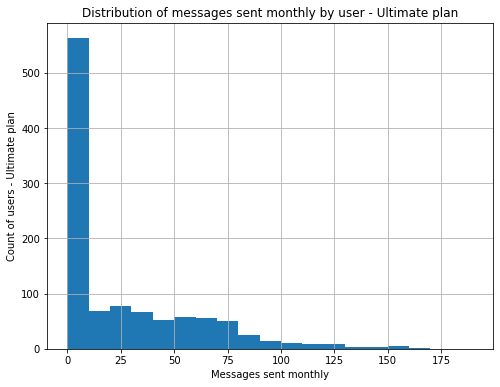

In [339]:
#Print distribution of messages sent monthly by ultimate users
active_users_df.query('plan=="ultimate"')['messages_sent'].hist(figsize=(8,6), bins=range(0,200,10))
plt.title('Distribution of messages sent monthly by user - Ultimate plan')
plt.ylabel('Count of users - Ultimate plan')
plt.xlabel('Messages sent monthly')

Text(0.5, 0, 'Messages sent monthly')

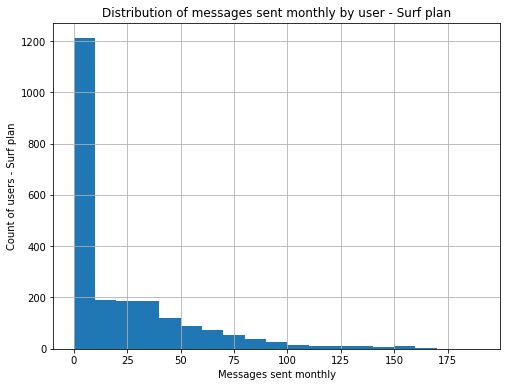

In [340]:
#Print distribution of messages sent monthly by surf users
active_users_df.query('plan=="surf"')['messages_sent'].hist(figsize=(8,6), bins=range(0,200,10))
plt.title('Distribution of messages sent monthly by user - Surf plan')
plt.ylabel('Count of users - Surf plan')
plt.xlabel('Messages sent monthly')

In [274]:
#Print statistics of messages sent by ultimate users each month
active_users_df.query('plan=="ultimate"')[ 'messages_sent'].describe()

count    1071.000000
mean       24.986928
std        33.541379
min         0.000000
25%         0.000000
50%         6.000000
75%        44.000000
max       166.000000
Name: messages_sent, dtype: float64

In [275]:
#Print statistics of messages sent by surf users each month
active_users_df.query('plan=="surf"')[ 'messages_sent'].describe()

count    2242.000000
mean       21.481267
std        31.435901
min         0.000000
25%         0.000000
50%         4.000000
75%        34.000000
max       266.000000
Name: messages_sent, dtype: float64

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


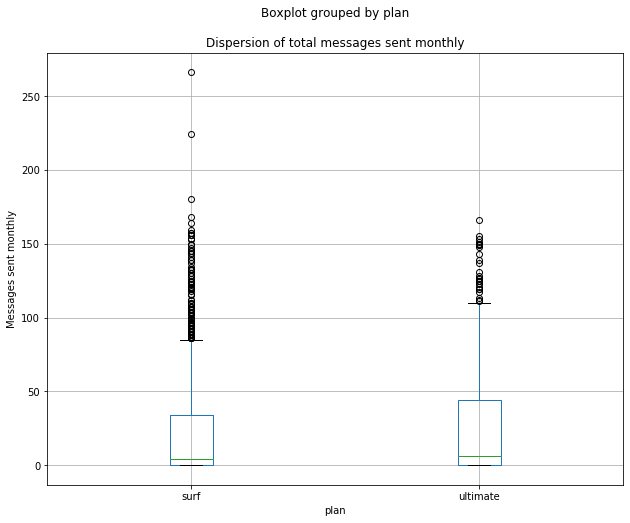

In [341]:
#Print boxplot showing the dispersion of messages sent monthly by the users of each plan
active_users_df.boxplot(by='plan',column='messages_sent', figsize=(10,8))
plt.title('Dispersion of total messages sent monthly')
plt.ylabel('Messages sent monthly')
plt.xlabel('plan')

plt.show()

The main observations regarding users behavior in relation to messages sent are:

1) The average messages sent by both plan users follow a similar pattern as calls duration: it raises as months go by. The average messages sent by ultimate users is a bit higher than those sent by surf users every month.

2) The distribution of messages sent is skewed to the right, with the highest peak falling between 0 and 15 text messages sent monthly by both plans users. There's another bunch between 15 and 100 which are not exactly equally distributed in both datasets (for surf users, the count of users sending more messages decreases steepwisely, while for ultimate users it's more fairly split within that range), but does not make a significant difference in users behavior.

3) There's a very irregular behavior when it comes to messaging, which is depicted by the massive dispersion noticed in both plans: the standard deviation is higher than the mean, and as outliers are placed to the right (positively), the median is much lower than the former. 

4) The mean and median are similar for both plans:

mean: 25 and 21 messages (ultimate and surf)

median: 6 and 4 messages (ultimate and surf)

Yet, surf plan has more and greater outliers (revealing more irregular texting habits) with a max of 266 messages vs 166 for ultimate. The extra pay for the former messages excess(266) is very low, adding up to only USD 6.50 (The maximum extra pay a surf user had to do due to messages excess). However, at least in the 75% of the cases, users fell below the boundary of messages included in their plan (50 messages). As for ultimate users, the max of messages sent (166) represents only the 10% of those available in their package.




### Internet

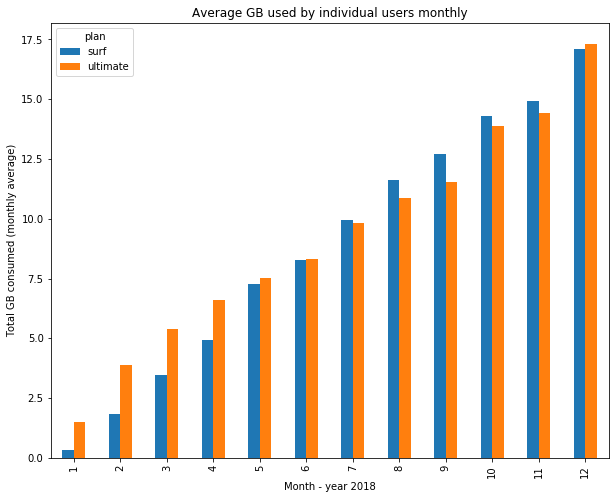

In [343]:
# Compare the amount of internet traffic consumed by users per plan

avg_gb= active_users_df.pivot_table(index='session_month',columns='plan', values='gb_used', aggfunc='mean')
avg_gb.plot(kind='bar', figsize=(10,8))
plt.title('Average GB used by individual users monthly')
plt.ylabel('Total GB consumed (monthly average)')
plt.xlabel('Month - year 2018')
plt.show()

Text(0.5, 0, 'GB consumed monthly')

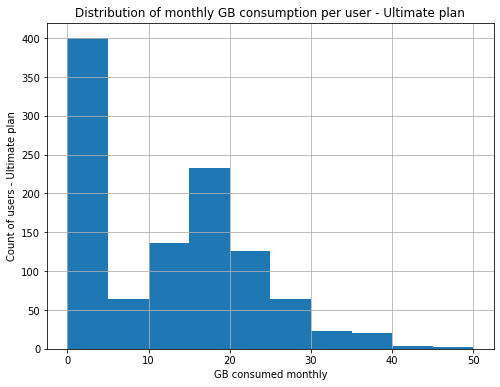

In [344]:
#Plot distribution of GB consumed by ultimate users monthly
active_users_df.query('plan=="ultimate"')['gb_used'].hist(bins=[0,5,10,15,20,25,30,35,40,45,50], figsize=(8,6))
plt.title('Distribution of monthly GB consumption per user - Ultimate plan')
plt.ylabel('Count of users - Ultimate plan')
plt.xlabel('GB consumed monthly')

Text(0.5, 0, 'GB consumed monthly')

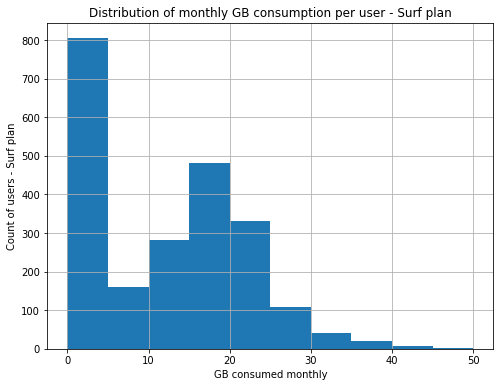

In [345]:
#Plot distribution of GB consumed by surf users monthly
active_users_df.query('plan=="surf"')['gb_used'].hist(bins=[0,5,10,15,20,25,30,35,40,45,50], figsize=(8,6))
plt.title('Distribution of monthly GB consumption per user - Surf plan')
plt.ylabel('Count of users - Surf plan')
plt.xlabel('GB consumed monthly')

In [280]:
#Print statistics of GB consumed by ultimate users monthly
active_users_df.query('plan=="ultimate"')['gb_used'].describe()

count    1071.000000
mean       11.459384
std        10.323460
min         0.000000
25%         0.000000
50%        13.000000
75%        19.000000
max        46.000000
Name: gb_used, dtype: float64

In [281]:
#Print statistics of GB consumed by surf users monthly
active_users_df.query('plan=="surf"')['gb_used'].describe()

count    2242.000000
mean       11.511151
std        10.093057
min         0.000000
25%         0.000000
50%        13.000000
75%        19.000000
max        70.000000
Name: gb_used, dtype: float64

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


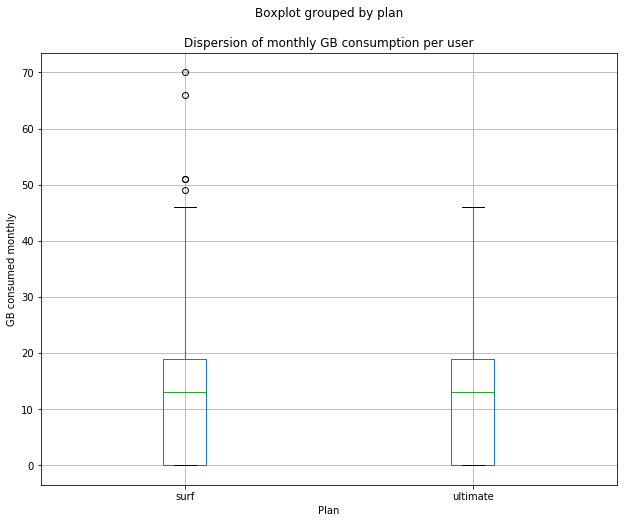

In [346]:
#Draw a boxplot to depict the dispersion of GB consumed monthly by users of each plan
active_users_df.boxplot(by='plan',column='gb_used', figsize=(10,8))
plt.title('Dispersion of monthly GB consumption per user')
plt.ylabel('GB consumed monthly')
plt.xlabel('Plan')
plt.show()

In [283]:
plans_df

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
plan_name,,,,,,,
surf,50,15,500,20,10,0.03,0.03
ultimate,1000,30,3000,70,7,0.01,0.01


As for internet consumption the most relevant insights are:

1) The average of GB consumed monthy per both plan users evolves similarly to messages sent and calls duration: it increases month by month, and slightly varies between plans. This is more likely due to the number of active users growing as well, and hence, better representing the expected value of the total population. 

2) The distribution of GB used is skewed to the right, with most monthly internet consumption values falling between 0 and 5 gb for users of both plans. Histograms depict a very similar distribution in the two plans, with a second high count of users consuming between 15 and 25 GB in some months (the count spikes at 20 GB). If we consider that the surf plan includes up to 15 gb and each extra gb costs $10, its users estimate revenue would be the sum of the monthly fee + approximately 5 gb x USD 10 = USD 20 + USD 50 = USD 70 (provided that they did not incurred in any extra messages/call minutes), what equals the ultimate plan cost, but allows for more flexibility if they don't know how long their web sessions will be beforehand (some months they may consume 16 gb and pay USD 30 and others 21 and pay USD 80, for example).

3) The mean, median and standard deviation are roughly the same for both plans, and considering that neither the mean nor the median are above the 15 gb included in the surf plan, this could be deemed as a considerable decision driver for choosing the cheapest plan (surf) . 

4) Surf plan has a few positive outliers, with a max of 76 gb consumed monthly vs 46 gb for ultimate. Either way, the dispersion up unitl the third quartile is almost the same for both datasets. The maximum internet extra pay for an ultimate user was of 16 GB x USD 7 = USD 112 whereas for a surf used it amounted to USD 550 (55 GB x USD 10).



### General conclusion on user behavior:

Considering monthly calls duration, messages sent and GB consumed as a whole, the insight we get from the previous study is that users have a very similar behavior regarding the three services hired in their plan:

- Average calls duration, messages sent and GB consumed share very similar values and follow the same pattern for every user (lower in month one, but gradually and consistently increasing throughout the year).

- The distributions of calls duration, messages and web sessions by user per month are also the same.

- The median and standard deviation of each variable under study for both plans are close to one another.

- Variables dispersion does not present major differences between plans.

Taking into account that in the 75% of the cases, users from both plans did not exceed the monthly allowance of messages and calls included in the cheapest package (surf), and that the maximum paid by surf users for extra messages was USD 6 and for extra calls was USD 30, we can conclude that the main decision driver when choosing a plan are the GB included on it. 

With that regard, we see that based on the maximum gb consumed monthly by a surf user, the extra internet purchase added up to USD 500. Furthermore, the median for both plans falls slightly below the gb included in surf plan (13 gb vs. 15 gb). However, the maximum internet monthly consumption for an ultimate user was less than half of the quantity available (3000 GB).


## Revenue

To assess which plan provides higher and more stable revenue per user, and as a whole, we'll plot the evolution of income month by month.
First, the plots will depict the average and median revenue per user of each plan. Next, we'll draw a chart of the aggregate monthly revenue per plan.

Text(0.5, 0, 'Month - year 2018')

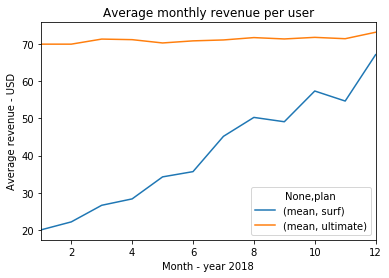

In [347]:
#Plot the evolution of the mean monthly
#revenue by user for both plans along the year

revenue_df_mean=active_users_df.pivot_table(index='session_month',columns='plan',values='monthly_revenue',aggfunc=['mean'])
revenue_df_mean.plot()
plt.title('Average monthly revenue per user')
plt.ylabel('Average revenue - USD')
plt.xlabel('Month - year 2018')

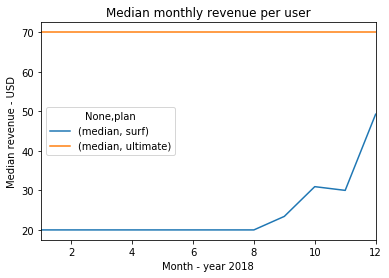

In [285]:
#Plot the evolution of the median monthly revenue
#by user for both plans along the year
revenue_df_median=active_users_df.pivot_table(index='session_month',columns='plan',values='monthly_revenue',aggfunc=['median'])
revenue_df_median.plot()
plt.title('Median monthly revenue per user')
plt.ylabel('Median revenue - USD')
plt.xlabel('Month - year 2018')
plt.show()

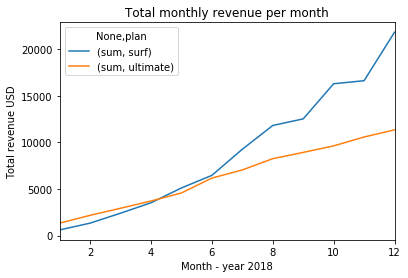

In [286]:
#Plot the evolution of the total monthly 
#revenue by user for both plans along the year
revenue_df_total=active_users_df.pivot_table(index='session_month',columns='plan',values='monthly_revenue',aggfunc=['sum'])
revenue_df_total.plot()
plt.title('Total monthly revenue per month')
plt.ylabel('Total revenue USD')
plt.xlabel('Month - year 2018')
plt.show()

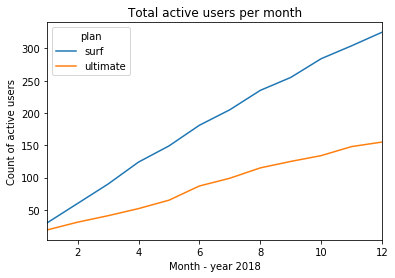

In [287]:
#Plot the count of active users for each plan
#along the year

total_users.plot()
plt.title('Total active users per month')
plt.ylabel('Count of active users')
plt.xlabel('Month - year 2018')
plt.show()

Text(0.5, 1.0, 'Distribution of monthly revenue per user - Ultimate plan')

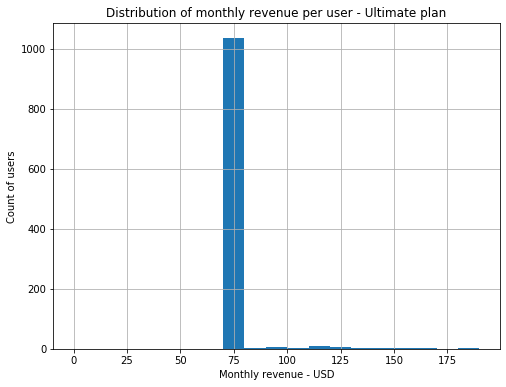

In [288]:
#Print the distribution of monthly revenue per user - Ultimate plan
active_users_df.query('plan=="ultimate"')['monthly_revenue'].hist(bins=range(0,200,10),figsize=(8,6))
plt.ylabel('Count of users')
plt.xlabel('Monthly revenue - USD')
plt.title('Distribution of monthly revenue per user - Ultimate plan')

Text(0.5, 1.0, 'Distribution of monthly revenue per user - Surf plan')

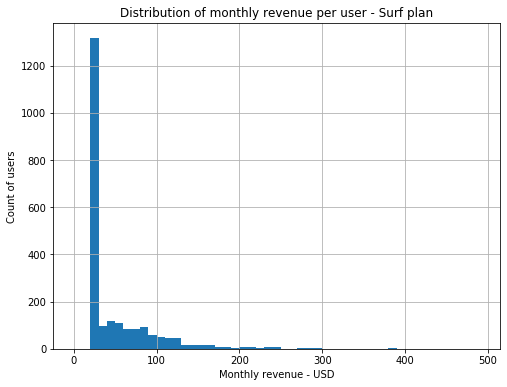

In [289]:
#Print the distribution of monthly revenue per user - Surf plan
active_users_df.query('plan=="surf"')['monthly_revenue'].hist(bins=range(0,500,10),figsize=(8,6))
plt.ylabel('Count of users')
plt.xlabel('Monthly revenue - USD')
plt.title('Distribution of monthly revenue per user - Surf plan')

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Dispersion of monthly revenue per user')

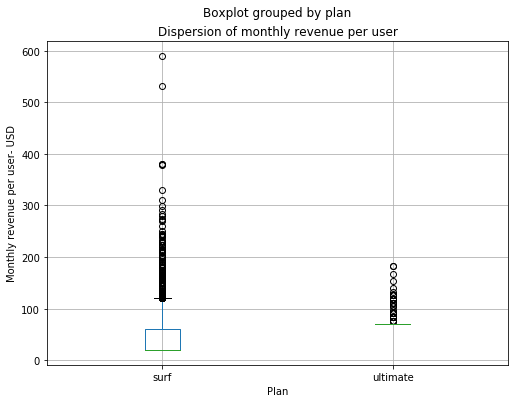

In [348]:
#Dispersion of monthly revenue per user
active_users_df.boxplot(by='plan', column='monthly_revenue',figsize=(8,6))
plt.ylabel('Monthly revenue per user - USD')
plt.xlabel('Plan')
plt.title('Dispersion of monthly revenue per user')

In [291]:
#Print statistics on monthly revenue per user for ultimate plan

active_users_df.query('plan=="ultimate"')['monthly_revenue'].describe()

count    1071.000000
mean       71.555556
std         9.403939
min        70.000000
25%        70.000000
50%        70.000000
75%        70.000000
max       182.000000
Name: monthly_revenue, dtype: float64

In [292]:
#Print statistics on monthly revenue per user for surf plan

active_users_df.query('plan=="surf"')['monthly_revenue'].describe()

count    2242.000000
mean       48.067649
std        49.683331
min        20.000000
25%        20.000000
50%        20.045000
75%        60.000000
max       590.370000
Name: monthly_revenue, dtype: float64

At an individual level, it's easy to see that ultimate users provide a much more stable and higher revenue in every monthly period.

However, since the total suscriptors to surf plan double those to ultimate plan, the aggregate revenue attributable to the former surpasses the latter's in April, steeply increasing towards the year end.

If the company decided to launch a new marketing campaign, it should aim to promote the ultimate plan to get more suscriptions to it.

## Probability of a user exceeding 19 GB monthly

Assuming that GB consumption for the total population of clients for both plans has a normal distribution, we'll:

1) First, formulate ONE TAILED HYPOTHESIS to test that that the mean of the total population's GB monthly consumption is greater than 12 GB. If we can reject the hypothesis:

2) We'll test whether it's less than 11. Provided that we can reject it as well:

3) We'll test the hypothesis that the mean monthly GB consumed individually for the total population is 11.5 (setting alpha to 0.01). In case we can't reject that hypothesis, next step we'll be:

4) Calculating the probability of anyone consuming anything above 19 gb (threshold up from which the surf plan would become more convenient) monthly based on a normal distribution of mu= 11.5 and sigma= the sample's standard dev.




1) Null hypothesis: the mean of the GB monthly consumption is greater than 12 GB

alpha = 0.05

method: one-tailed hypothesis



In [293]:
#Test the hypothesis that the mean of the total population is greater than 12 gb

optimal_value = 12

alpha =0.01 

sample_gb= active_users_df['gb_used']

results = st.ttest_1samp(sample_gb, optimal_value) # write your code here

print(f'Sample mean: {sample_gb.mean()}')
print('p-value: ',results.pvalue/2)

if results.pvalue/2 < alpha and sample_gb.mean() < optimal_value:
    print('We reject the null hypothesis: the mean of the total population is not greater than 12 gb')
else:
    print("We can't reject the null hypothesis")


Sample mean: 11.494415937217024
p-value:  0.0021154749896171443
We reject the null hypothesis: the mean of the total population is not greater than 12 gb


2) Null hypothesis: the mean of the GB monthly consumption is less than 11 gb

alpha = 0.01

method: one-tailed hypothesis



In [294]:
#Test the hypothesis that the mean of the total population is less than 11 GB

optimal_value = 11

alpha =0.01

sample_gb= active_users_df['gb_used']

results = st.ttest_1samp(sample_gb, optimal_value) 

print(f'Sample mean: {sample_gb.mean()}')
print('p-value: ',results.pvalue/2)

if results.pvalue/2 < alpha and sample_gb.mean() > optimal_value:
    print('We reject the null hypothesis: the mean gb consumed monthly by the total population is not less than 11')
else:
    print("We can't reject the null hypothesis")


Sample mean: 11.494415937217024
p-value:  0.0025765890086804602
We reject the null hypothesis: the mean gb consumed monthly by the total population is not less than 11


3) Null hypothesis: the mean of the GB monthly consumption is  11.5 gb

alpha = 0.01

method: Two-tailed hypothesis



In [295]:
#Test the hypothesis that the mean of the total population is 11.5 GB
target_value = 11.5

alpha =0.01 

sample_gb= active_users_df['gb_used']

results = st.ttest_1samp(sample_gb, target_value) # write your code here

print(f'Sample mean: {sample_gb.mean()}')
print('p-value: ',results.pvalue)

if results.pvalue < alpha :
    print('We reject the null hypothesis: the mean gb consumed monthly by the total population is not 11.5')
else:
    print("We can't reject the null hypothesis")

Sample mean: 11.494415937217024
p-value:  0.9747813951453268
We can't reject the null hypothesis


4) Create a normal distribution with a mu of 11.5 and a sigma equal to the sample's standard deviation.

5) Calculate the cdf at 20 GB.



In [296]:
#Store normal distribution

mu= 11.5
sigma= sample_gb.std()

gb_distr= st.norm(mu, sigma)

#calculate the probability that the gb consumed is higher than 19 GB

result1= 1- gb_distr.cdf(19)

result1

0.2303449747777534

This result means that users have an 77% of probability of consuming less than 20 Gb and a 23% to reach or exceed such value.

This confirms the idea in the previous bullet point: it's less risky and more profitable to get customers suscribed to the ultimate plan.

6) Calculate the ppf for 90% of the users:


In [297]:
#Estimate the max gb consumed by the 90% of the users 
#assuming a normal distribution
mu= 11.5
sigma= sample_gb.std()

gb_distr= st.norm(mu, sigma)

#Estimate the max GB consumed by the 90% of the population

result2= gb_distr.ppf(0.90)
result2

24.52899619457665

7) Calculate the % of the users that are likely to spend more than 10 gb:


In [298]:
#Store normal distribution

mu= 11.5
sigma= sample_gb.std()

gb_distr= st.norm(mu, sigma)

#calculate the probability that the gb consumed is higher than 10 GB

result1= 1- gb_distr.cdf(10)

result1

0.558647981051089

90% of the users are likely to use less than 25 GB, what makes it look as if a plan including 30 GB is not worth for them. Anyway, since the 55% of the users are likely to use more than 10 gb monthly,one idea to get surf users upgraded to ultimate is lowering the gb included to 10 gb, increasing the cost of extra gb to USD 15, and offering them to switch plans if in a given month they reached or exceeded the USD 70 (because it's cheaper that month).


## Impact of upgrading surf users

Next, we'll estimate how the revenue would have varied if the GB included in surf plan were reduced to 10 GB, plus extra GB consumed being charged with a USD 15 fee, and gb included in ultimate being raised to 35. 

We'll work on the assumption that every surf user who ever reached or exceeded the USD 70 pay in any month was given the possibility to upgrade starting in the month of such excess, and the offer was accepted.


In [299]:
active_users_df.query('plan=="surf" and monthly_revenue>=70')

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_active,monthly_revenue
116,2,1359,266.0,0.0,20.0,surf,2,13,2018-02-08,2019-01-01,"Colorado Springs, CO MSA",50,15,500,20,10,0.03,0.03,1,70.00
139,2,1498,244.0,0.0,20.0,surf,2,13,2018-02-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03,1,70.00
164,3,1099,728.0,22.0,21.0,surf,2,13,2018-02-26,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03,1,86.84
185,3,1171,300.0,0.0,25.0,surf,1,13,2018-01-27,2019-01-01,"Boston-Cambridge-Newton, MA-NH MSA",50,15,500,20,10,0.03,0.03,1,120.00
212,3,1268,307.0,10.0,20.0,surf,1,13,2018-01-13,2019-01-01,"Fresno, CA MSA",50,15,500,20,10,0.03,0.03,1,70.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3300,12,1486,347.0,10.0,20.0,surf,12,13,2018-12-05,2019-01-01,"Orlando-Kissimmee-Sanford, FL MSA",50,15,500,20,10,0.03,0.03,1,70.00
3302,12,1488,721.0,0.0,20.0,surf,5,13,2018-05-15,2019-01-01,"Baton Rouge, LA MSA",50,15,500,20,10,0.03,0.03,1,76.63
3308,12,1495,492.0,0.0,24.0,surf,9,13,2018-09-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03,1,110.00
3311,12,1498,339.0,0.0,23.0,surf,2,13,2018-02-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03,1,100.00


In [300]:
#Copy dataframe
active_users_upgrade= active_users_df.copy()

active_users_upgrade

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_active,monthly_revenue
0,1,1003,0.0,0.0,0.0,surf,1,13,2018-01-28,2019-01-01,"Tulsa, OK MSA",50,15,500,20,10,0.03,0.03,1,20.0
1,1,1011,0.0,0.0,0.0,ultimate,1,13,2018-01-18,2019-01-01,"Cleveland-Elyria, OH MSA",1000,30,3000,70,7,0.01,0.01,1,70.0
2,1,1019,0.0,0.0,0.0,surf,1,13,2018-01-16,2019-01-01,"Jacksonville, FL MSA",50,15,500,20,10,0.03,0.03,1,20.0
3,1,1029,0.0,0.0,0.0,surf,1,13,2018-01-05,2019-01-01,"Tampa-St. Petersburg-Clearwater, FL MSA",50,15,500,20,10,0.03,0.03,1,20.0
4,1,1042,114.0,0.0,2.0,surf,1,13,2018-01-15,2019-01-01,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",50,15,500,20,10,0.03,0.03,1,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,12,1495,492.0,0.0,24.0,surf,9,13,2018-09-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03,1,110.0
3309,12,1496,294.0,11.0,17.0,surf,2,13,2018-02-20,2019-01-01,"New Orleans-Metairie, LA MSA",50,15,500,20,10,0.03,0.03,1,40.0
3310,12,1497,300.0,50.0,11.0,ultimate,12,13,2018-12-10,2019-01-01,"Los Angeles-Long Beach-Anaheim, CA MSA",1000,30,3000,70,7,0.01,0.01,1,70.0
3311,12,1498,339.0,0.0,23.0,surf,2,13,2018-02-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,15,500,20,10,0.03,0.03,1,100.0


In [301]:
#change gb included of surf users to 10 and cost of extra gb to USD 15
active_users_upgrade.loc[active_users_upgrade['plan']=="surf",'gb_per_month_included']= 10
active_users_upgrade.loc[active_users_upgrade['plan']=="surf",'usd_per_gb']= 15


In [302]:
#change gb included of ultimate users to 35
active_users_upgrade.loc[active_users_upgrade['plan']=="ultimate",'gb_per_month_included']= 35


In [303]:
#re-calculate monthly revenue
active_users_upgrade['monthly_revenue'] = active_users_upgrade.apply(monthly_revenue, axis=1)

In [304]:
#Printe count of unique surf users who exceed 70 USD in any month

active_users_upgrade.query('plan=="surf" and monthly_revenue >=70')['user_id'].nunique()

280

In [305]:
#`print unique surf users who exceeded 70 USD each month
for i in range(12):
    a=i+1
    print("month {} :{}".format(a,active_users_upgrade.query('plan=="surf" and monthly_revenue >=70 and session_month==@a')['user_id'].nunique()))

month 1 :0
month 2 :4
month 3 :14
month 4 :22
month 5 :46
month 6 :64
month 7 :88
month 8 :112
month 9 :136
month 10 :166
month 11 :192
month 12 :235


In [306]:
active_users_upgrade

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_active,monthly_revenue
0,1,1003,0.0,0.0,0.0,surf,1,13,2018-01-28,2019-01-01,"Tulsa, OK MSA",50,10,500,20,15,0.03,0.03,1,20.0
1,1,1011,0.0,0.0,0.0,ultimate,1,13,2018-01-18,2019-01-01,"Cleveland-Elyria, OH MSA",1000,35,3000,70,7,0.01,0.01,1,70.0
2,1,1019,0.0,0.0,0.0,surf,1,13,2018-01-16,2019-01-01,"Jacksonville, FL MSA",50,10,500,20,15,0.03,0.03,1,20.0
3,1,1029,0.0,0.0,0.0,surf,1,13,2018-01-05,2019-01-01,"Tampa-St. Petersburg-Clearwater, FL MSA",50,10,500,20,15,0.03,0.03,1,20.0
4,1,1042,114.0,0.0,2.0,surf,1,13,2018-01-15,2019-01-01,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",50,10,500,20,15,0.03,0.03,1,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,12,1495,492.0,0.0,24.0,surf,9,13,2018-09-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,10,500,20,15,0.03,0.03,1,230.0
3309,12,1496,294.0,11.0,17.0,surf,2,13,2018-02-20,2019-01-01,"New Orleans-Metairie, LA MSA",50,10,500,20,15,0.03,0.03,1,125.0
3310,12,1497,300.0,50.0,11.0,ultimate,12,13,2018-12-10,2019-01-01,"Los Angeles-Long Beach-Anaheim, CA MSA",1000,35,3000,70,7,0.01,0.01,1,70.0
3311,12,1498,339.0,0.0,23.0,surf,2,13,2018-02-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,10,500,20,15,0.03,0.03,1,215.0


In [307]:
#pick a random surf user who has ever paid below and above 70usd
active_users_upgrade.loc[active_users_upgrade['user_id']==1483]

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_active,monthly_revenue
439,4,1483,112.0,0.0,1.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,20.00
650,5,1483,415.0,15.0,15.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,95.00
918,6,1483,491.0,5.0,13.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,65.00
1222,7,1483,679.0,10.0,14.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,85.37
1570,8,1483,424.0,6.0,11.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,35.00
1949,9,1483,477.0,14.0,12.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,50.00
2368,10,1483,490.0,6.0,14.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,80.00
2819,11,1483,410.0,4.0,10.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,20.00
3297,12,1483,0.0,0.0,0.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,20.00


In [308]:
# Assume that surf users who ever exceeded a USD 69 monthly pay
# were given the chance to upgrade since the month at which the excess 
# took place and they accepted because it's cheaper

active_users_upgrade.loc[(active_users_upgrade['plan']=='surf') &(active_users_upgrade['monthly_revenue']>=70),'plan'] = 'ultimate'

active_users_upgrade

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_active,monthly_revenue
0,1,1003,0.0,0.0,0.0,surf,1,13,2018-01-28,2019-01-01,"Tulsa, OK MSA",50,10,500,20,15,0.03,0.03,1,20.0
1,1,1011,0.0,0.0,0.0,ultimate,1,13,2018-01-18,2019-01-01,"Cleveland-Elyria, OH MSA",1000,35,3000,70,7,0.01,0.01,1,70.0
2,1,1019,0.0,0.0,0.0,surf,1,13,2018-01-16,2019-01-01,"Jacksonville, FL MSA",50,10,500,20,15,0.03,0.03,1,20.0
3,1,1029,0.0,0.0,0.0,surf,1,13,2018-01-05,2019-01-01,"Tampa-St. Petersburg-Clearwater, FL MSA",50,10,500,20,15,0.03,0.03,1,20.0
4,1,1042,114.0,0.0,2.0,surf,1,13,2018-01-15,2019-01-01,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",50,10,500,20,15,0.03,0.03,1,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,12,1495,492.0,0.0,24.0,ultimate,9,13,2018-09-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,10,500,20,15,0.03,0.03,1,230.0
3309,12,1496,294.0,11.0,17.0,ultimate,2,13,2018-02-20,2019-01-01,"New Orleans-Metairie, LA MSA",50,10,500,20,15,0.03,0.03,1,125.0
3310,12,1497,300.0,50.0,11.0,ultimate,12,13,2018-12-10,2019-01-01,"Los Angeles-Long Beach-Anaheim, CA MSA",1000,35,3000,70,7,0.01,0.01,1,70.0
3311,12,1498,339.0,0.0,23.0,ultimate,2,13,2018-02-04,2019-01-01,"New York-Newark-Jersey City, NY-NJ-PA MSA",50,10,500,20,15,0.03,0.03,1,215.0


In [309]:
#verify the change
active_users_upgrade.loc[active_users_upgrade['user_id']==1483]

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_active,monthly_revenue
439,4,1483,112.0,0.0,1.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,20.00
650,5,1483,415.0,15.0,15.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,95.00
918,6,1483,491.0,5.0,13.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,65.00
1222,7,1483,679.0,10.0,14.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,85.37
1570,8,1483,424.0,6.0,11.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,35.00
1949,9,1483,477.0,14.0,12.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,50.00
2368,10,1483,490.0,6.0,14.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,80.00
2819,11,1483,410.0,4.0,10.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,20.00
3297,12,1483,0.0,0.0,0.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,20.00


In [310]:
#change to ultimate for the months following that of the excess:

for i in range(len(active_users_upgrade)):
    session_month= active_users_upgrade.loc[i,'session_month']
    
    user_id= active_users_upgrade.loc[i,'user_id']
    plan_month= active_users_upgrade.loc[i,'plan']
    prev_month= session_month-1
    
    #if there is info for the previous month, store previous month and previous plan into two variables
    if len(active_users_upgrade[(active_users_upgrade['session_month']==prev_month) & (active_users_upgrade['user_id']==user_id)])>0:
        
        
        plan_prev_month = active_users_upgrade.loc[(active_users_upgrade['session_month']==prev_month) & (active_users_upgrade['user_id']==user_id),'plan']
        
        if plan_prev_month.iloc[0]=='ultimate' and plan_month== 'surf':
            active_users_upgrade.loc[i,'plan']= 'ultimate'
        else:
            continue
    else:
        continue
           

In [311]:
#verify it worked correctly
active_users_upgrade.query('user_id==1483')

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_active,monthly_revenue
439,4,1483,112.0,0.0,1.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,20.00
650,5,1483,415.0,15.0,15.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,95.00
918,6,1483,491.0,5.0,13.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,65.00
1222,7,1483,679.0,10.0,14.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,85.37
1570,8,1483,424.0,6.0,11.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,35.00
1949,9,1483,477.0,14.0,12.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,50.00
2368,10,1483,490.0,6.0,14.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,80.00
2819,11,1483,410.0,4.0,10.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,20.00
3297,12,1483,0.0,0.0,0.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,1,20.00


In [312]:
#drop columns with plan features

active_users_upgrade = active_users_upgrade.iloc[:,:11].copy()

In [313]:
plans_df_modified=plans_df


plans_df_modified.loc['ultimate','gb_per_month_included']=35
plans_df_modified.loc['surf','gb_per_month_included']=10
plans_df_modified.loc['surf','usd_per_gb']=15

plans_df_modified


,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
plan_name,,,,,,,
surf,50,10,500,20,15,0.03,0.03
ultimate,1000,35,3000,70,7,0.01,0.01


In [314]:
#merge plan info:

active_users_upgrade= active_users_upgrade.merge(plans_df_modified, left_on='plan', right_index=True, how='left')
active_users_upgrade.query('user_id==1483')

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
439,4,1483,112.0,0.0,1.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03
650,5,1483,415.0,15.0,15.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01
918,6,1483,491.0,5.0,13.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01
1222,7,1483,679.0,10.0,14.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01
1570,8,1483,424.0,6.0,11.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01
1949,9,1483,477.0,14.0,12.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01
2368,10,1483,490.0,6.0,14.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01
2819,11,1483,410.0,4.0,10.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01
3297,12,1483,0.0,0.0,0.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01


In [315]:
#Apply monthly revenue function once again

active_users_upgrade ['monthly_revenue'] = active_users_upgrade.apply(monthly_revenue, axis=1)



In [316]:
active_users_upgrade.query('user_id==1483')

,session_month,user_id,call_duration,messages_sent,gb_used,plan,reg_month,churn_month,reg_date,churn_date,city,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,monthly_revenue
439,4,1483,112.0,0.0,1.0,surf,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",50,10,500,20,15,0.03,0.03,20.0
650,5,1483,415.0,15.0,15.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01,70.0
918,6,1483,491.0,5.0,13.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01,70.0
1222,7,1483,679.0,10.0,14.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01,70.0
1570,8,1483,424.0,6.0,11.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01,70.0
1949,9,1483,477.0,14.0,12.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01,70.0
2368,10,1483,490.0,6.0,14.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01,70.0
2819,11,1483,410.0,4.0,10.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01,70.0
3297,12,1483,0.0,0.0,0.0,ultimate,4,13,2018-04-25,2019-01-01,"Chicago-Naperville-Elgin, IL-IN-WI MSA",1000,35,3000,70,7,0.01,0.01,70.0


In [317]:
#sum of total revenue before the change
active_users_df['monthly_revenue'].sum()

184403.66999999998

In [318]:
#sum of total revenue after the change
active_users_upgrade['monthly_revenue'].sum()

184657.61000000002

Text(0.5, 0, 'Month - year 2018')

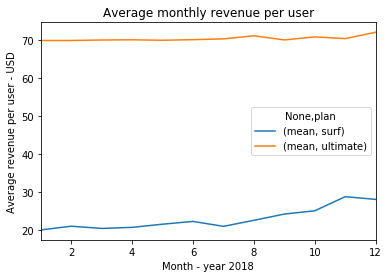

In [349]:
#Plot the evolution of the mean monthly revenue by user 
#for both plans along the year
#after the change
revenue_upgrade_mean=active_users_upgrade.pivot_table(index='session_month',columns='plan',values='monthly_revenue',aggfunc=['mean'])
revenue_upgrade_mean.plot()
plt.title('Average monthly revenue per user')
plt.ylabel('Average revenue per user - USD')
plt.xlabel('Month - year 2018')

Text(0.5, 0, 'Month - year 2018')

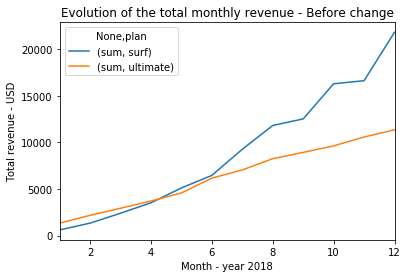

In [350]:
#Plot the evolution of the total monthly revenue 
#for both plans along the year
#before the change
revenue_df_total.plot()
plt.title('Evolution of the total monthly revenue - Before change')
plt.ylabel('Total revenue - USD')
plt.xlabel('Month - year 2018')

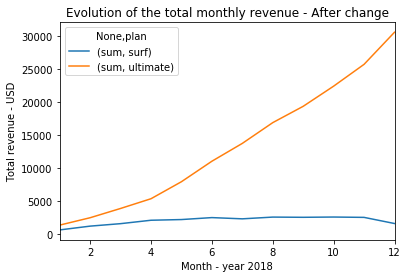

In [351]:
#Plot the evolution of the total monthly revenue 
#by user for both plans along the year
#after the change

revenue_upgrade_total=active_users_upgrade.pivot_table(index='session_month',columns='plan',values='monthly_revenue',aggfunc=['sum'])
revenue_upgrade_total.plot()
plt.title('Evolution of the total monthly revenue - After change')
plt.ylabel('Total revenue - USD')
plt.xlabel('Month - year 2018')
plt.show()

Text(0.5, 0, 'Month - year 2018')

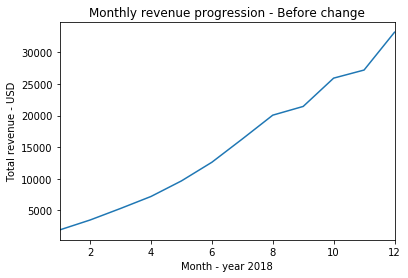

In [352]:
#plot total revenue per month before the change
active_users_df.groupby('session_month')['monthly_revenue'].sum().plot()
plt.title('Monthly revenue progression - Before change')
plt.ylabel('Total revenue - USD')
plt.xlabel('Month - year 2018')

Text(0.5, 0, 'Month - year 2018')

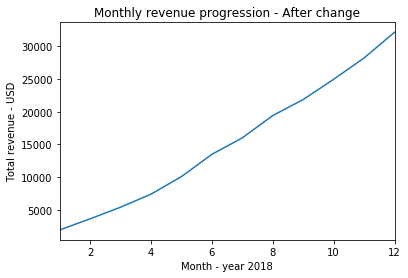

In [353]:
#plot total revenue per month after the change
active_users_upgrade.groupby('session_month')['monthly_revenue'].sum().plot()
plt.title('Monthly revenue progression - After change')
plt.ylabel('Total revenue - USD')
plt.xlabel('Month - year 2018')

In [324]:
#print average revenue per user before the change
active_users_df['monthly_revenue'].mean()

55.66063084817385

In [325]:
#print average revenue per user after the change
active_users_upgrade['monthly_revenue'].mean()

55.73728041050408

Test the hypothesis that the average monthly revenue per user did not change

3) Null hypothesis: The average monthly revenue per user didn't change

alpha = 0.05

method: Hypothesis on the Equality of the Means of Paired Samples



In [326]:
before= active_users_df['monthly_revenue']
after= active_users_upgrade['monthly_revenue']

alpha=0.05

results = st.ttest_rel(before, after)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis: the mean changed")
else:
    print("We can't reject the null hypothesis")

p-value:  0.8910562330567244
We can't reject the null hypothesis


Since 280 surf users exceeded the USD 69 monthly pay in at least one month, we assumed that they accepted the offer to upgrade to the ultimate plan.

Even though we could not reject the hypothesis that the mean monthly revenue per user before and after the change was the same, it's clear that this change had a positive impact, since 280 surf users were upgraded to ultimate (many of them in the last months of the year, what is expected to improve performance the following year).



## Test statistical hypotheses

### Hypothesis one: the average revenue from users of the Ultimate and Surf calling plans differs

Null hypothesis: "The average monthly revenue from users of ultimate plan is equal to the one from users of Surf plan"

Alternative hypothesis: "The average monthly revenue from users of the Ultimate and Surf calling plans differs"

Statistical test: Hypothesis on the Equality of Two Population Mean.

alpha= 0.05


In [327]:
#Print variances to decide on whether there are reasons to set equal_var as false
print(np.var( active_users_df.query('plan=="ultimate"')['monthly_revenue']))
print(np.var(active_users_df.query('plan=="surf"')['monthly_revenue']))

88.35148874364562
2467.3324313614826


In [328]:
# Test the hypotheses

ultimate_plan_revenue= active_users_df.query('plan=="ultimate"')['monthly_revenue']
surf_plan_revenue= active_users_df.query('plan=="surf"')['monthly_revenue']

alpha=0.05

results=st.ttest_ind(ultimate_plan_revenue,surf_plan_revenue, equal_var=False)
print(results.pvalue)

if results.pvalue<alpha:
    
    print('We reject the null hypothesis. The average revenue from both plans differ')
    
else:
    
    
    print('We can\'t reject the null hypothesis')

4.1453379306928634e-95
We reject the null hypothesis. The average revenue from both plans differ


### Hypothesis two: the average revenue from users in the NY-NJ area is different from that of the users from the other regions

Null hypothesis: "The average revenue from users in the NY-NJ area is equal to that of the users from the other regions"

Alternative hypothesis: "The average revenue from users in the NY-NJ area is different than that of the users from the other regions"

Statistical test: Hypothesis on the Equality of Two Population Mean.

alpha=0.05


In [329]:
#define dataset storing only users from NY-NJ 
ny_nj_active_users_df= active_users_df.query('city.str.contains("NY-NJ")')

In [330]:
#define dataset storing only users from every other city 
other_active_users_df= active_users_df.query('city.str.contains("NY-NJ")==False')

In [331]:
#print variance and mean of monthly revenue of users from NYNJ
print(np.var(ny_nj_active_users_df['monthly_revenue']),ny_nj_active_users_df['monthly_revenue'].mean())

1597.1100357676207 52.25917582417583


In [332]:
#print variance and mean of monthly revenue of users from other cities 
print(np.var(other_active_users_df['monthly_revenue']), other_active_users_df['monthly_revenue'].mean())

1860.0084956571518 56.33182508131549


In [333]:
# Test the hypotheses

array_1=ny_nj_active_users_df['monthly_revenue']
array_2=other_active_users_df['monthly_revenue']
alpha=0.05

#Variance is similar, so we'll leave equal_var as true
result= st.ttest_ind(array_1,array_2)

print(f'P-value= {result.pvalue}')

if result.pvalue < alpha:
    print('We reject the null hypothesis. The average revenue of users from NYNJ differs from the rest of the cities')
else:
    print('We can\'t reject the null hypothesis')


P-value= 0.041445206941637176
We reject the null hypothesis. The average revenue of users from NYNJ differs from the rest of the cities


## General conclusion


The main objective of this project is to carry out a preliminary analysis of the two prepaid plans offered by the telecom operator Megaline, Surf and Ultimate. 

Based on a relatively small selection of 500 Megaline customers and focusing on who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent and the internet MB they consumed in 2018, this analysis is aimed to understand the clients' behavior and determine which prepaid plan brings in more revenue.


The following datasets containing info on the individual calls, messages and web sessions are to be stored in separate dataframes, as well as the table showing user's personal information and the one with each plan's features.

**1)Data preparation:** 

After loading and getting an overview of the data, some fixes and additions were made to each dataset to better prepare it for studying it:

**1) Plans: data on the plans:**

plan_name — calling plan name

usd_monthly_fee — monthly charge in US dollars

minutes_included — monthly minute allowance

messages_included — monthly text allowance

mb_per_month_included — data volume allowance (in megabytes)

usd_per_minute — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)

usd_per_message — price per text after exceeding the package limits

usd_per_gb — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

***Description of the plans***

***Surf***

Monthly charge: $20

500 monthly minutes, 50 texts, and 15 GB of data

After exceeding the package limits:

1 minute: 3 cents

1 text message: 3 cents

1 GB of data: $10

***Ultimate***

Monthly charge: $70

3000 monthly minutes, 1000 text messages, and 30 GB of data

After exceeding the package limits:

1 minute: 1 cent

1 text message: 1 cent

1 GB of data: $7

***Data wrangling***

a) Since monthly megabytes consumption will be rounded up to Gigabytes, mb_per_month_included were converted into GB.

b) plan_name was set as the index of the dataframe, to more easily merge it with other datasets based on the plan each user has.

**2) Users:**

user_id — unique user identifier

first_name — user's name

last_name — user's last name

age — user's age (years)

reg_date — subscription date (dd, mm, yy)

churn_date — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)

city — user's city of residence

plan — calling plan name

***Data wrangling***

a) reg_date & churn date were converted to datetime.

b) The only column with missing values is: churn_date. The empty cells add up to 466.

As the Database contains values for the year 2018 and missing values mean the calling plan was being used when this database was extracted, they were replaced by the following year start date (1/1/2019). The idea of not using the year end date is to distinguish the ones that were still active at the end of the year from the ones whose churn date matches the last day of the year.

c) Registration month and churn month: since revenue from each user will be calculated on a monthly basis, two columns were added: reg_month and churn_month.

Based on their values, it's easy to calculate whether the user was active (was charged with the monthly pay) at a given month.

This will be estimated on the assumption that user's are charged both for the month they suscribed and the month they discontinued the service, regardless of the day of the month at which they became active/inactive and the calls, messages or GB they used.
For those users whose churn_date was missing and filled out with "1/1/2019" churn_month was set to 13 (so that it's always greater than the session month, and the user is deemed as active if it had already registered by that month).

**3) Calls:**

id — unique call identifier

call_date — call date

duration — call duration (in minutes)

user_id — the identifier of the user making the call

***Data wrangling***

a) call_date was converted to datetime, and duration was rounded up, since even if the call lasted just one second, it will be counted as one minute for invoicing.

b) Call month: Based on each call date, we'll add a column with the month at which they took place for adding up the total minutes cost per user each period. 

c) "duration" column name was changed by "call_duration".

**4) Messages**

id — unique text message identifier

message_date — text message date

user_id — the identifier of the user sending the text

***Data wrangling***

a) message_date was converted to datetime.

b) message month: Based on the date each message was sent, we added a column with the month for adding up the total messages sent per user each monthly period. 


**5) Internet**

id — unique session identifier

mb_used — the volume of data spent during the session (in megabytes)

session_date — web session date

user_id — user identifier

***Data wrangling***

a) session_date was converted to datetime.

b) For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes. Hence, MB will be totalized per used_id & month, and rounded up later on.

c) session month: Based on the date of each session, we will add a column with the month for adding up the total MB used per user in each monthly period. 


**2) Aggregate monthly data per user**

For calls, messages and internet datasets, the total calls duration, messages sent and MB consumed was added up by user each month.

At this point, total MB consumed monthly were aggregated and rounded up to GB.


After that, a new dataframe indexed with month(from 1 to 12) and each unique user_id (repeated once each month) was created. Its total length was 500 users x 12 months = 6000 rows. The previously aggregated data was merged to this dataframe, as well as some relevant users' features:

'plan','reg_month', 'churn_month','reg_date','churn_date','city'

Finally, based on each user's plan, data on the GB, minutes and messages included, as well as on the monthly pay and the cost of extras was merged to the dataset as well.


**3) Create dataset with active users only** 

If at a given month the user had not registered yet, or had already discontinued the service (churn month < month), the monthly pay was not charged to her/him in that period (revenue=0). To separate only rows were the user was active that month (every user will be accounted for as active if the reg month = session month or churn_month = month, regardless of the day they registered/resigned, or their consumption). 

Once we got active users, we proceeded to calculate the monthly revenue provided by them as follows:

1) Set revenue = monthly pay if user_active = 1, or to 0 otherwise.

2) Subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan.

3) Separate active users in a new dataframe.

**4) Study user behavior**

Considering monthly calls duration, messages sent and GB consumed as a whole, the insight we get from our analysis is that users have a very similar behavior regarding the three services hired in their plan:

Average calls duration, messages sent and GB consumed share very similar values and follow the same pattern for every user (lower in month one, but gradually and consistently increasing throughout the year).

The distributions of calls duration, messages and web sessions by user per month are also the same.

The median and standard deviation of each variable under study for both plans are close to one another.
    
Variables dispersion does not present major differences between plans.

Taking into account that in the 75% of the cases, users from both plans did not exceed the monthly allowance of messages and calls included in the cheapest package (surf), and that the maximum paid by surf users for extra messages was USD 6 and for extra calls was USD 30, we can conclude that the main decision driver when choosing a plan are the GB included on it.

With that regard, we see that based on the maximum gb consumed monthly by a surf user, the extra internet purchase added up to USD 500. Furthermore, the median for both plans falls slightly below the gb included in surf plan (13 gb vs. 15 gb). However, the maximum internet monthly consumption for an ultimate user was less than half of the quantity available (3000 GB).

**5) Revenue**

At an individual level, it's easy to see that ultimate users provide a much more stable and higher revenue in every monthly period.

However, since the total suscriptors to surf plan (2242) double those to ultimate plan (1071), the aggregate revenue attributable to the former surpasses the latter's in April, steeply increasing towards the year end. Also, revenue provided by surf users was higher due to the cost of extra gb, minutes and messages consumed.

If the company decided to launch a new marketing campaign, it should aim to promote the ultimate plan to get more suscriptions to it.

**6) Probability of a user consuming more than 19 GB (Normal distribution assumption) (at 20 gb, the revenue is the same than that of the ultimate plan, provided that the minutes and the messages limits aren't exceeded):**

If users were highly likely to consume 20 GB or more, it would be more profitable that they were suscribed to the surf plan than the ultimate. If such probability is high, then we would prefer future customers to suscribe to the surf plan and pay the extra GB at USD 10 each. To proceed with this analysis:

Based on the sample composed by all active users from both plans:

1) The hypothesis that the mean of the total users population is higher than 12 was rejected (One tailed hypothesis - alpha = 0.01)

2) The hypothesis that the mean of the total users population is less than 11 was rejected (One tailed hypothesis - alpha = 0.01)

3) We checked that we could not reject the hypotheisis that the mean of the total population is = 11.5 GB (Two tailed hypothesis - alpha = 0.01)

4) We created a normal distribution with mu = 11.5 (mean) and sigma = standard deviation of the sample).

5) We calculated the cumulative distribution function of 19 GB (at 20 gb we prefer them to be surf users, as we could charge extra messages and minutes), getting as a result that users have an 77% of probability of consuming less than 20 Gb and a 23% to reach or exceed such value.

6) On top of that, the 90% of the users are likely to consume less than 25 GB, that's why maybe suscribing to a plan including 30 GB is not worth for them.


This confirms the idea in the previous bullet point: it's less risky and more profitable to get customers suscribed to the ultimate plan.

7) Since the 55% of the users are likely to use more than 10 gb monthly,one idea to get surf users upgraded to ultimate is lowering the gb included to 10 gb, increasing the cost of extra gb to USD 15, and offering them to switch plans if in a given month they reached or exceeded the USD 70 (because it's cheaper that month).


**6) Plan to upgrade surf users to ultimate**

Next, we studied how the revenue would have varied if the GB included by ultimate were raised to 35 GB, and the ones in surf plan were reduced to 10 GB, plus extra GB consumed being charged with a USD 15 fee instead of USD 10.

We performed the analysis on the supposition that every user who ever reached or exceeded the USD 69 monthly pay in any month was given the possibility to upgrade starting in the month of the excess, and the offer was accepted because the monthly pay resulted cheaper (USD 20 + 4GBx USD15= USD 80 > USD 70).


Since 280 surf users would have exceeded the USD 69 monthly pay under the new plans features, we assumed that they accepted the offer to upgrade to the ultimate plan.


Even though we could not reject the hypothesis that the mean monthly revenue per user before and after the change was the same (by applying the method the Equality of the Means of Paired Samples), it's clear that this change had a positive impact, since 280 surf users were upgraded to ultimate (many of them in the last months of the year, what is expected to improve performance the following year).



**7) Test statistical hypothesis**

***Hypothesis one: the average revenue from users of the Ultimate and Surf calling plans differs***

Null hypothesis: "The average monthly revenue from users of ultimate plan is equal to the one from users of Surf plan"

Statistical test: Hypothesis on the Equality of Two Population Mean.
        
alpha= 0.05

result: We reject the null hypothesis. The average revenue from both plans differ.
    
***Hypothesis two: the average revenue from users in the NY-NJ area is different from that of the users from the other regions***

Null hypothesis: "The average revenue from users in the NY-NJ area is equal to that of the users from the other regions"

Statistical test: Hypothesis on the Equality of Two Population Mean.

alpha=0.05

Result: We reject the null hypothesis. The average revenue of users from NYNJ differs from the rest of the cities
